In [2]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

In [3]:
data_dir = '/bsuscratch/zacharykeskinen/data/uavsar/images'
fig_dir = expanduser('~/uavsar/figures/coherence_collections/')
pol_cols = {'VV':'red', 'VH':'green','HV':'aqua','HH':'blue'}
np.random.seed(20220503)

## Scene Wide Coherence - First we can investigate scene wide coherence vs temporal baseline with subsets for two different peg headings and polarizations

In [3]:
res = pd.DataFrame()
cols = ['Lowman, CO']
for col in cols:
    pairs = glob(join(data_dir, col, '*'))
    pairs = [pair for pair in pairs if basename(pair) != 'tmp']
    for pair in tqdm(pairs):
        coh_fps = glob(join(pair, '*cor.grd.tiff'))
        for coh_fp in coh_fps:
            dic = {}
            desc = pd.read_csv(glob(join(pair, '*.csv'))[0], index_col = 0)
            dic['first_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 1'])
            dic['second_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 2'])
            dic['heading'] = desc.loc['value', 'peg heading']
            dic['pol'] = basename(coh_fp).split('_')[6][4:]
            with rio.open(coh_fp) as src:
                arr = src.read(1)
                dic['coh_25'], dic['coh_75'] = np.nanquantile(arr, [0.25, 0.75])
                dic['median_coh'] = np.nanmedian(arr)
            res = pd.concat([res, pd.DataFrame.from_records([dic])])
res['diff_dt'] = (res['second_dt'] - res['first_dt']).astype('timedelta64[D]')

        

100%|██████████| 17/17 [10:15<00:00, 36.18s/it]


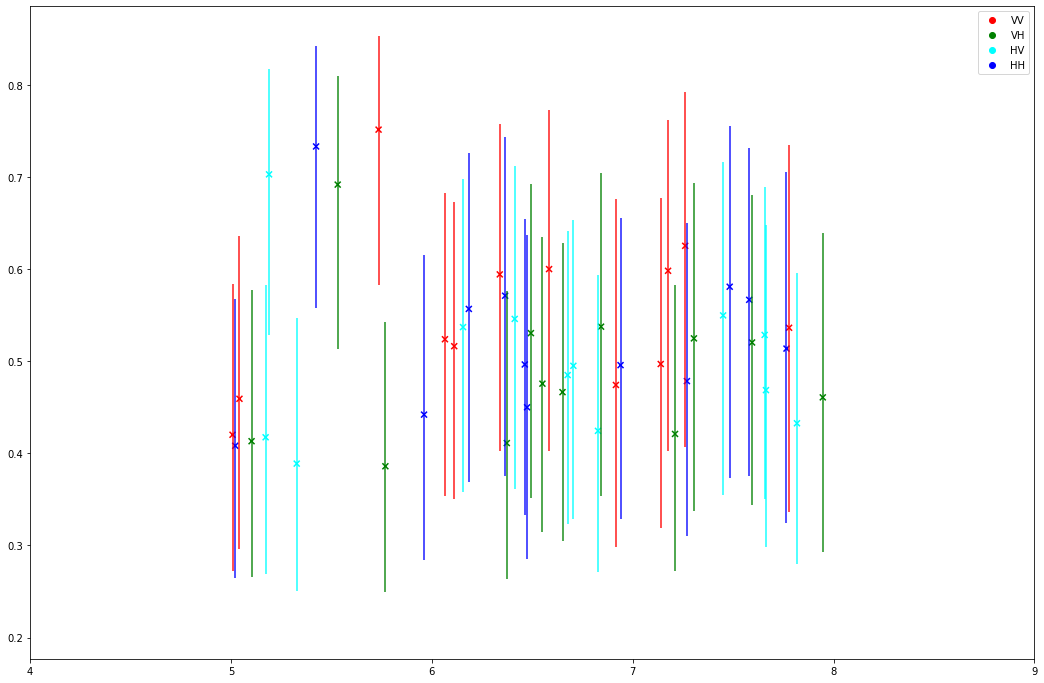

In [11]:
pol_cs = [pol_cols[i] for i in res.pol]
plt.figure(figsize = (18,12))
jitter = np.random.random(len(res.diff_dt))
plt.vlines(x = res.diff_dt + jitter, ymin = res['coh_25'], ymax = res['coh_75'], colors = pol_cs, alpha = 0.9)
plt.scatter(x = res.diff_dt + jitter, y = res.median_coh, marker = 'x', c = pol_cs)
# plt.xscale('log')

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.xlim(4,9)
plt.savefig(join(fig_dir, 'temp_pol_coh.png'), dpi = 300)

## Compare sd change from snotels to windowed coherence aroundthe snotel

In [1]:
from meso_extract import meso_notebook_extract

In [4]:
?meso_notebook_extract

Signature:
meso_notebook_extract(
    img_fp,
    ann_csv,
    anc_img=None,
    token=None,
    box_side=4,
)
Docstring:
Function for use in notebooks to capture image bounds and query and return time series of weather observations that overlap non-null values in image.
Params:
img_fp - filepath to tiff file to extract from
ann_csv - filepath to annotation csv
anc_img - anncilary image to also extract values from at same locations as original
token - Mesopy token (optional). Can be obtained at http://mesowest.org/api/signup/.
File:      ~/uavsar/src/funcs/meso_extract.py
Type:      function


In [5]:
res = pd.DataFrame()
cols = ['Lowman, CO']
for col in cols:
    pairs = glob(join(data_dir, col, '*'))
    pairs = [pair for pair in pairs if basename(pair) != 'tmp']
    for pair in tqdm(pairs):
        coh_fps = glob(join(pair, '*cor.grd.tiff'))
        for coh_fp in coh_fps:
            dic = {}
            csv_fp = glob(join(pair, '*.csv'))[0]
            desc = pd.read_csv(csv_fp, index_col = 0)
            dic['first_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 1'])
            dic['second_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 2'])
            dic['heading'] = desc.loc['value', 'peg heading']
            dic['pol'] = basename(coh_fp).split('_')[6][4:]
            meso_res = meso_notebook_extract(img_fp=coh_fp, ann_csv = csv_fp)
            dic['meso_result'] = meso_res
            res = pd.concat([res, pd.DataFrame.from_records([dic])])
res['diff_dt'] = (res['second_dt'] - res['first_dt']).astype('timedelta64[D]')

  6%|▌         | 1/17 [01:52<30:06, 112.89s/it]


KeyboardInterrupt: 

In [32]:
res['meso_result'].iloc[0]['BANNER SUMMIT'].keys()

dict_keys(['datetime', 'img_arr', 'snow_depth_set_1', 'elev', 'lat', 'long', 'tz', 'img_fp'])

In [25]:
df = pd.DataFrame(res['meso_result'].iloc[0]['BANNER SUMMIT']['snow_depth_set_1'], index = res['meso_result'].iloc[0]['BANNER SUMMIT']['datetime']).resample('D').mean()

In [30]:
df.iloc[-1].values[0] - df.iloc[0].values[0]

81.27999999999997